*JSC270, Winter 2020 - Prof. Chevalier*

# <center>  Assignment 2 - Yelp  </center>
<center> Karl Hendrik Nurmeots, February 19, 2020 </center>



***

In [113]:
# Some of these packages may have to be conda installed instead of pip installed depending on your system
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from haversine import haversine, Unit
import seaborn as sns
import simplejson as json
import geopandas as gpd
import descartes
from shapely.geometry import Point, Polygon, mapping, shape, LineString
from shapely.ops import polygonize
import shapely
import re
from fuzzywuzzy import fuzz
from sklearn.linear_model import LinearRegression
import string
import contextily as ctx
import geoplot as gplt
import geoplot.crs as gcrs
from shapely.wkt import loads
import scipy as scp
from typing import Tuple
from functools import partial
import pyproj
import shapely.ops as ops

In [2]:
plt.style.use("ggplot")
plt.rcParams['figure.figsize'] = [15,7]

# Introduction

[Yelp](https://www.yelp.com/) is a business directory service and crowd-sourced review forum.

# The Yelp Dataset

For this report we will be using the [Yelp dataset](https://www.yelp.com/dataset/challenge). **For this report to compile, you must download the data from the website and place it in extracted form in the 'data' directory!**. This requires you to provide your email and name.

Per the [Yelp dataset license](https://s3-media1.fl.yelpcdn.com/assets/srv0/engineering_pages/06cb5ad91db8/assets/vendor/yelp-dataset-agreement.pdf), one is allowed to create a report of the data such as this one only for academic purposes. Any sort of disclosure or sharing of the dataset itself is strictly prohibited - this is a private dataset. Any use of the dataset must not disparage Yelp.

A more detailed overview of the dataset can be found on the [dataset documentation page](https://www.yelp.com/dataset/documentation/main). Due to the comprehensive extent of the dataset we will only provide a short insight into what the dataset contains. The dataset consists of 6 JSON files: 

`business.json` contains information about each establishment in the dataset such as the business' name, ID, location (address and coordinates), Yelp rating and review count, attributes (e.g. if the business provides a takeout service), category, and opening hours.

`review.json` contains information about each review, namely the author ID, business reviewed ID, rating, date, full review text, and the number of "useful", "funny" and "cool" votes the review has recieved. Author ID maps to the corresponding user in user.json, and business ID maps to the business in business.json.

`user.json` contains information about users' IDs, first names, their friends' user IDs, and info about the feedback they have recieved on their reviews (e.g. total "useful" votes).

`checkin.json` contains each business' ID and a collection of timestamps when users have checked in at that business. Again, the business ID maps to business.json.

`tip.json` contains information about short tips that users have posted, and is structured similarly to review.json. Tips are essentially very short reviews, but do not give a numeric rating about the business. Instead of tracking the number of different votes, the number of "compliments" the tip has recieved is tracked.

`photo.json` contains metadata about photos users have posted: the business' ID the picture is about, the author's user ID, the picture's caption and label (e.g. "food"). 

For this analysis, we will only use `business.json` and `review.json`.

In [3]:
def json_to_dataframe(file: str, nrows = 0) -> pd.DataFrame:
    """Returns a Pandas dataframe from the JSON file located at <file>."""
    with open(file, 'r', encoding="utf8") as f:
        if nrows == 0:
            content = f.readlines()
        else:
            content = []
            for i in range(nrows):
                content.append(f.readline())
        
    return pd.DataFrame([json.loads(row) for row in content])

In [155]:
# Reading in the 2 JSON files
business = json_to_dataframe("data/business.json")
review = json_to_dataframe("data/review.json", 500)

# The coordinates in the dataset are too precise and would cause computational issues later on,
# so we will round them. With 4 decimal points the coordinates are still precise enough to locate
# buildings.
#business.latitude = business.apply(lambda row: round(row.latitude, 5), axis=1)
#business.longitude = business.apply(lambda row: round(row.longitude, 5), axis=1)

In [5]:
business

business_id                             name  \
0       1SWheh84yJXfytovILXOAQ       Arizona Biltmore Golf Club   
1       QXAEGFB4oINsVuTFxEYKFQ       Emerald Chinese Restaurant   
2       gnKjwL_1w79qoiV3IC_xQQ      Musashi Japanese Restaurant   
3       xvX2CttrVhyG2z1dFg_0xw  Farmers Insurance - Paul Lorenz   
4       HhyxOkGAM07SRYtlQ4wMFQ              Queen City Plumbing   
...                        ...                              ...   
192604  nqb4kWcOwp8bFxzfvaDpZQ               Sanderson Plumbing   
192605  vY2nLU5K20Pee-FdG0br1g                         Chapters   
192606  MiEyUDKTjeci5TMfxVZPpg                   Phoenix Pavers   
192607  zNMupayB2jEHVDOji8sxoQ            Beasley's Barber Shop   
192608  c1f_VAX1KIK8-JoVhjbYOw                   Oriental Relax   

                               address             city state postal_code  \
0          2818 E Camino Acequia Drive          Phoenix    AZ       85016   
1                 30 Eglinton Avenue W      Mississauga    ON     L5R 3E7   
2            10110 Johnston Rd, Ste 15        Charlotte    NC       28210   
3        15655 W Roosevelt St, Ste 237         Goodyear    AZ       85338   
4       4209 Stuart Andrew Blvd, Ste F        Charlotte    NC       28217   
...                                ...              ...   ...         ...   
192604                                  North Las Vegas    NV       89032   
192605              17440 Yonge Street        Newmarket    ON     L3Y 6Y9   
192606                 21230 N 22nd St          Phoenix    AZ       85024   
192607                  4406 E Main St             Mesa    AZ       85205   
192608           3735 S Las Vegas Blvd        Las Vegas    NV       89109   

         latitude   longitude  stars  review_count  is_open  \
0       33.522143 -112.018481    3.0             5        0   
1       43.605499  -79.652289    2.5           128        1   
2       35.092564  -80.859132    4.0           170        1   
3       33.455613 -112.395596    5.0             3        1   
4       35.190012  -80.887223    4.0             4        1   
...           ...         ...    ...           ...      ...   
192604  36.213732 -115.177059    5.0             9        1   
192605  44.052658  -79.481850    4.5             3        1   
192606  33.679992 -112.035569    4.5            14        1   
192607  33.416137 -111.735743    4.5            15        1   
192608  36.107267 -115.171920    4.0             3        0   

                                               attributes  \
0                                {'GoodForKids': 'False'}   
1       {'RestaurantsReservations': 'True', 'GoodForMe...   
2       {'GoodForKids': 'True', 'NoiseLevel': 'u'avera...   
3                                                    None   
4       {'BusinessAcceptsBitcoin': 'False', 'ByAppoint...   
...                                                   ...   
192604             {'BusinessAcceptsCreditCards': 'True'}   
192605  {'RestaurantsPriceRange2': '2', 'BikeParking':...   
192606  {'BusinessAcceptsCreditCards': 'True', 'ByAppo...   
192607  {'RestaurantsPriceRange2': '1', 'BusinessAccep...   
192608  {'BikeParking': 'False', 'RestaurantsPriceRang...   

                                               categories  \
0                                       Golf, Active Life   
1       Specialty Food, Restaurants, Dim Sum, Imported...   
2                       Sushi Bars, Restaurants, Japanese   
3                           Insurance, Financial Services   
4       Plumbing, Shopping, Local Services, Home Servi...   
...                                                   ...   
192604  Water Purification Services, Water Heater Inst...   
192605               Books, Mags, Music & Video, Shopping   
192606  Home Services, Contractors, Landscaping, Mason...   
192607                             Beauty & Spas, Barbers   
192608                             Massage, Beauty & Spas   

                                                    hours  
0     

# Analysis

Oddly enough, the dataset does not contain information about what country each business is located in, so to start off, let's visualize all of our businesses on a world map. For this and all following map visualizations we will be using the Mercator projection.

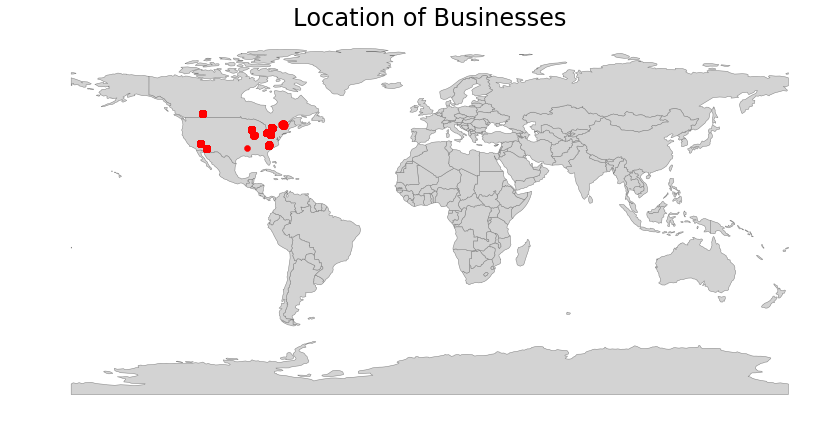

In [171]:
# Get world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# Create GeoDataFrame for business
gdf = gpd.GeoDataFrame(
    business, geometry=gpd.points_from_xy(business.longitude, business.latitude), crs=world.crs)

ax = world.plot(
    color='lightgrey', edgecolor='grey')

gdf.plot(ax=ax, color='red')

plt.title("Location of Businesses", fontsize=24)
plt.axis('off')
plt.show()

All of the businesses in the dataset are located either in the US or Canada. We have information about the businesses' postal codes, and we can notice that USA and Canada have different postal code formats: US postal codes include only numbers, while Canadian ones always include alphabetic letters, so we can easily create a new column `country` to distinguish the country the business is located in based on their postal code.

In [157]:
def get_country(row: pd.Series) -> str:
    """Given a Pandas series representing a row about a business, returns the country
       the business is located in.
       
       Note that postal codes in Canada always contain letters, while US postal codes do not."""
    
    if re.search('[a-zA-Z]', row.postal_code) is None:
        return "USA"
    return "Canada"

business['country'] = business.apply(lambda row: get_country(row), axis=1)

Let's see how the businesses in the dataset distribute in terms of the country they are located in:

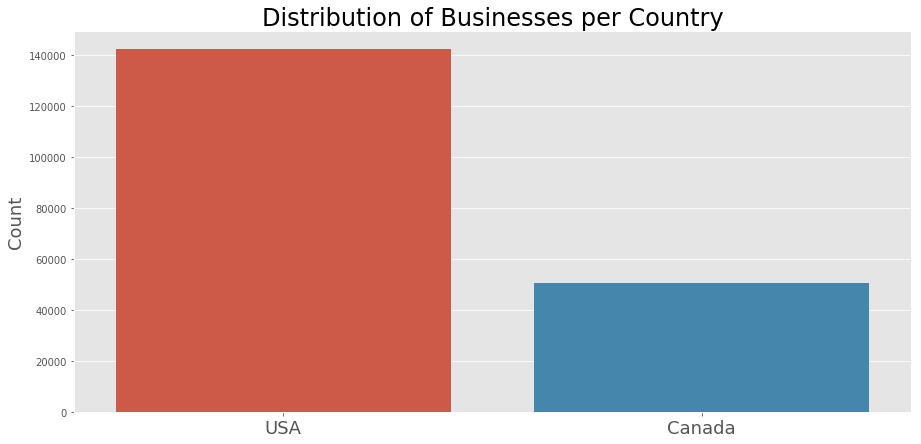

In [9]:
sns.countplot(x=business.country)

plt.title("Distribution of Businesses per Country", fontsize=24)
plt.ylabel("Count", fontsize=18)
plt.xlabel("")
plt.xticks(fontsize=18)
plt.show()

We can see that over 70% of the businesses in the dataset are located in the US.

Moving on, we would like to see how the businesses distribute across cities in the dataset. When we take a look at the different cities present in the dataset, however, we will realise that there are many inconsistencies in the city names: for example, both "Montréal" and "Montreal" show up.

We would like to fix this issue, so we will use FuzzyWuzzy, a fuzzy string matching package. Our businesses dataset is very large, and this type of string fixing is very demanding, so we will have to compromise: we will only try to fix the names of the largest 100 cities in the US and Canada (separately). A quick glimpse into the data tells us that most businesses are located in these cities, so it is also more likely that there are inconsistencies in the city names for these businesses.

More precisely, we will look at the biggest cities by population based on Wikipedia. Here's our reference data: [Canada](https://en.wikipedia.org/wiki/List_of_the_100_largest_municipalities_in_Canada_by_population) and [USA](https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population).

In [158]:
# Reading in data from Wikipedia

url_ca = 'https://en.wikipedia.org/wiki/List_of_the_100_largest_municipalities_in_Canada_by_population'
url_usa = 'https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population'

canada = pd.read_html(url_ca, attrs = {"class":"wikitable sortable"})[0]
canada_cities = canada.Municipality.values

usa = pd.read_html(url_usa, attrs = {"class":"wikitable sortable"})[0]
usa_cities = usa.City.values[:100]

# Reading in the USA cities data sometimes adds weird tags to the city names, so we will
# remove them.
for i in range(len(usa_cities)):
    usa_cities[i] = re.sub('\[.\]$', '', usa_cities[i])

In [159]:
def fix_city_name(row: pd.Series) -> str:
    """Given a Pandas Series representing a row about a business,
       returns the fuzzy corrected city name for that business."""
    city = row.city
    cutoff = 90
    
    # If we get a match of >= cutoff %, return that match.
    # Otherwise, return the original city name.
    if row.country == 'Canada':
        for ca in canada_cities:
            if fuzz.token_set_ratio(city, ca) >= cutoff:
                return ca
    else:
        for us in usa_cities:
            if fuzz.token_set_ratio(city, us) >= cutoff:
                return us
    return city

business['city'] = business.apply(lambda row: fix_city_name(row), axis=1)

With the city names corrected, we can take a look at how the businesses distribute based on the city they are located in:

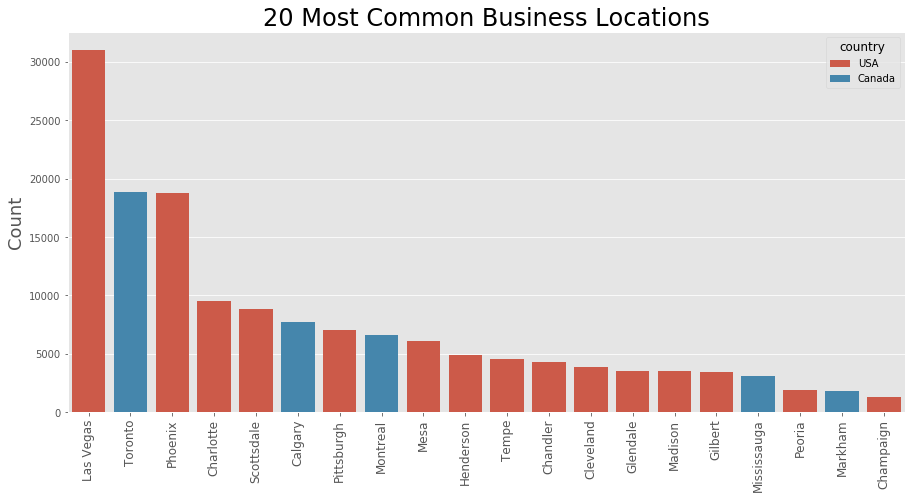

In [12]:
sns.countplot(business.city, order=business.city.value_counts().iloc[:20].index,
             hue=business.country, dodge=False)

plt.xticks(rotation=90)
plt.title("20 Most Common Business Locations", fontsize=24)
plt.ylabel("Count", fontsize=18)
plt.xlabel("")
plt.xticks(fontsize=12)

plt.show()

In total, there are just over 1000 different cities in the dataset, however the businesses in the top 20 most common cities account for about 78% of all the businesses in the dataset. As evident, this list is dominated by cities in the US, accompanied by some of the biggest cities in Canada. The most common city in the dataset is Las Vegas, which accounts for about 15% of all businesses.

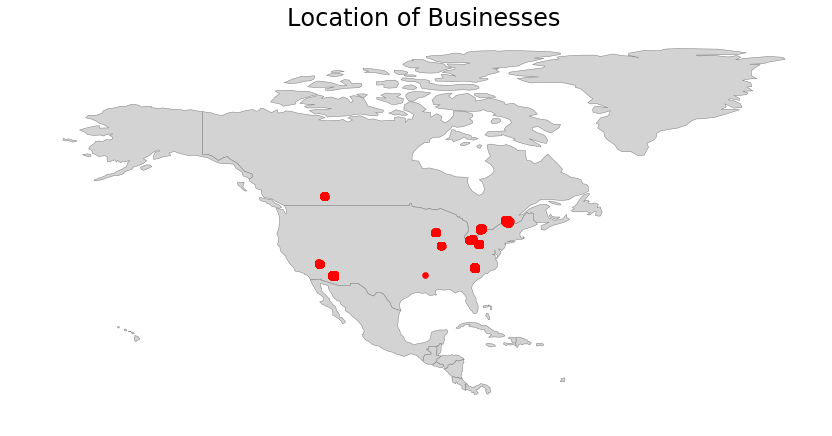

In [13]:
ax = world[world.continent=='North America'].plot(
    color='lightgrey', edgecolor='grey')

gdf.plot(ax=ax, color='red', alpha=1)

plt.title("Location of Businesses", fontsize=24)
plt.axis('off')
plt.show()

When we map the location of businesses, we can see that the dataset contains businesses from very few regions: most of them are clustered together in the east US and GTA area, with some others situated in the southwestern parts of the US and Canada.

### Business Categories

We would like to analyse what categories of businesses are present in the dataset. The dataset has a column `categories`, which contains usually multiple tags for each business. The data is not well formatted: for example, the most common value in `categories` is "Restaurants, Pizza", while the third most common value is "Pizza, Restaurants". Because of all of the different possible tags and their permutations, we need to reduce the number of categories to get a better overview of what's going on.

To do this, we will extract the separate category tags from the categories column (e.g. 'Pizza' and 'Restaurants' from 'Pizza, Restaurants'), and find the total count for how many times each such category shows up in the dataset. There are many different tags used in the dataset, so we will only look at the 20 most frequent ones.

In [17]:
# We are also extracting information about the availability of bike parking per category,
# which we will need later. It is more efficient to do this here

keywords = {}

for i, bus in business.iterrows():
    cat = bus.categories
    att = bus.attributes
    if cat is not None:
        for word in cat.split(','):
            if word.strip() in keywords:
                keywords[word.strip()][0] += 1
            else:
                keywords[word.strip()] = [1, 0]
        
            if att is not None and 'BikeParking' in att and att['BikeParking'] == 'True':
                keywords[word.strip()][1] += 1

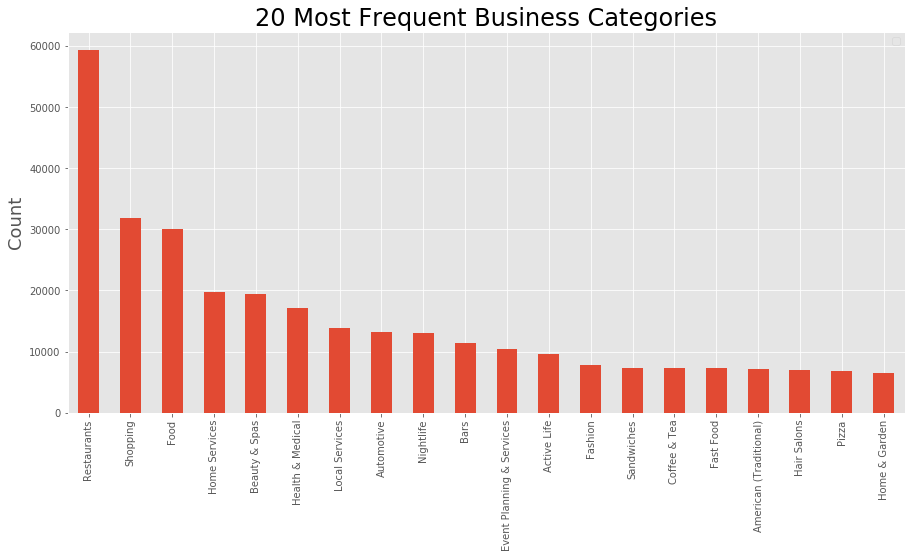

In [18]:
# Create new df containing top 20 categories based on count, and the number and proportion of such businesses
# that have bike parking available
cats = pd.DataFrame.from_dict(keywords, orient='index')
cats = cats.reset_index()
cats.columns = ['category', 'count', 'bike_parking']
cats['prop_bike_parking'] = cats.apply(lambda row: 100*row.bike_parking/row['count'], axis=1)
topcats = cats.sort_values('count', ascending=False).head(20)


topcats.plot.bar(x='category', y='count', label='')

plt.title("20 Most Frequent Business Categories", fontsize=24)
plt.ylabel("Count", fontsize=18)
plt.xlabel("")
plt.legend("")
plt.show()

For the most part, this sort of splitting works: most of the categories we are left with are "general" as they describe a very broad category of business. However, we can still see that there's likely some overlap: "Food", "Sandwiches", "Fast Food" and others could be considered subsets of "Restaurants". At the same time, not every business with the tag "Fast Food" is also tagged with "Restaurants", so in many cases there is no overlap.

To get a slightly better idea of what's going on, let's divide these categories into three simpler ones: Food & Drink, Retail, and Services. This sort of categorizing will not be perfect because some of the tags can be very vague: for example, notice "American (Traditional)". Presumably this denotes businesses that serve American food, however we can't exatly be sure either. The way we will categorize our business types is definitely subjective and debatable, but it will still give us a simplified overview of the situation.

In [22]:
def get_simple_category(row: pd.Series) -> str:
    """Given a Pandas Series representing a row about a business,
    returns whether this business belongs to one of our simple categories:
    'Food & Drink', 'Retail', or 'Services'. """
    # Define simple category based on category entry
    fnd=['Restaurants', 'Food', 'Bars', 'Sandwiches', 'Coffee & Tea',
         'Fast Food', 'American (Traditional)', 'Pizza']
    ret=['Shopping', 'Home & Garden', 'Fashion']
    # Everything else in the top 20 belongs to 'Services'
    
    if row.category in fnd:
        return "Food & Drink"
    elif row.category in ret:
        return "Retail"
    return "Services"

topcats['simple_cat'] = topcats.apply(lambda row: get_simple_category(row), axis=1)

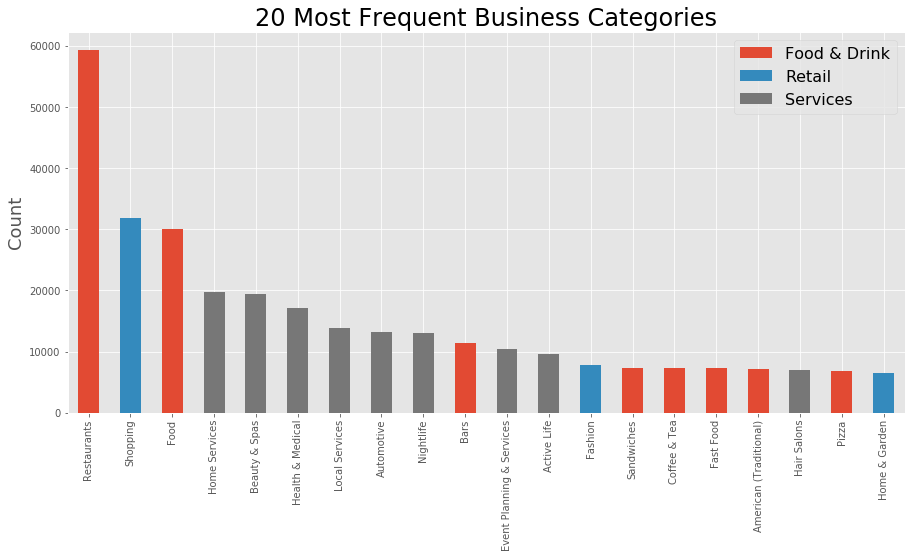

In [30]:
# Decide on bar color based on simple_cat. Skipping 'C2' for better contrast
color_dict = {'Food & Drink': 'C0', 'Retail': 'C1', 'Services': 'C3'}
colors = [color_dict[cat] for cat in topcats.simple_cat]

topcats.plot.bar(x='category', y='count', label='', color=colors)

# Create custom legend based on our colormapping
legend_elements = [Patch(facecolor='C0', label='Food & Drink'),
                  Patch(facecolor='C1', label='Retail'),
                  Patch(facecolor='C3', label='Services')]

plt.title("20 Most Frequent Business Categories", fontsize=24)
plt.ylabel("Count", fontsize=18)
plt.xlabel("")
plt.legend(handles=legend_elements, fontsize=16)
plt.show()

Let's also combine this with the total counts within the top 20 for our three simple categories:

In [57]:
topcats.head()

category  count  bike_parking  prop_bike_parking    simple_cat
3     Restaurants  59371         29478          49.650503  Food & Drink
15       Shopping  31878         15292          47.970387        Retail
6            Food  29989         17404          58.034613  Food & Drink
17  Home Services  19729          1180           5.981043      Services
24  Beauty & Spas  19370         10632          54.889004      Services

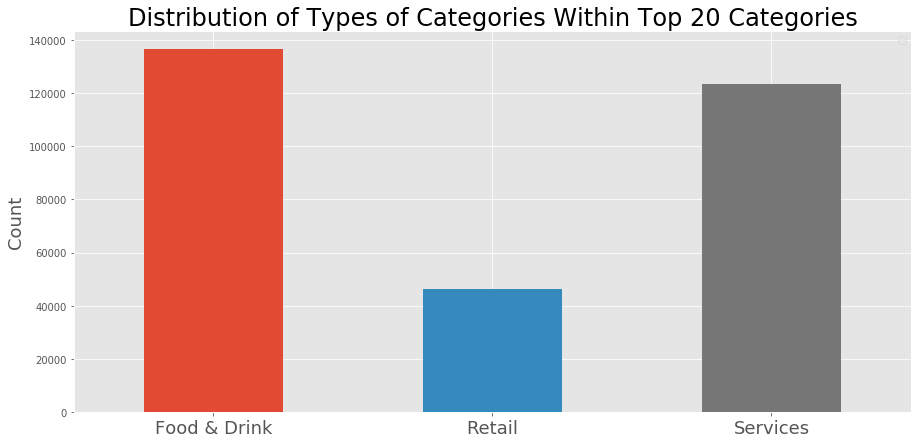

In [65]:
# Get total counts per simple_cat and create new df
# Again, we will keep track of bike parking for a later section, too
d = {'Food & Drink':[0, 0], "Retail":[0,0], "Services":[0,0]}
for i, row in topcats.iterrows():
    d[row.simple_cat][0] += row['count']
    d[row.simple_cat][1] += row.bike_parking
    
df = pd.DataFrame.from_dict(d, orient='index')
df = df.reset_index()
df.columns = ['cat', 'count', 'bike_parking']

df.plot.bar(x='cat', y='count', color=['C0', 'C1', 'C3'], label='')

plt.xticks(rotation=0, fontsize=18)
plt.xlabel("")
plt.ylabel("Count", fontsize=18)
plt.title("Distribution of Types of Categories Within Top 20 Categories", fontsize=24)
plt.legend("")
plt.show()

From these two visualizations we can see that food and drink categories are most common due to "Restaurants" and "Food" being so common, but they are closely followed by services categories, which consist of many categories with relatively smaller counts. Businesses dealing in retail are much less common in the dataset.

### Bike Parking

We would like to know what types of businesses tend to have bike parking. In the dataset, the column `attributes` contains various attributes relating to each business. One of them is 'BikeParking', which can evaluate to true or false.

First, let's take a look at how common bike parking is among the 20 most common business categories we saw in the previous section.

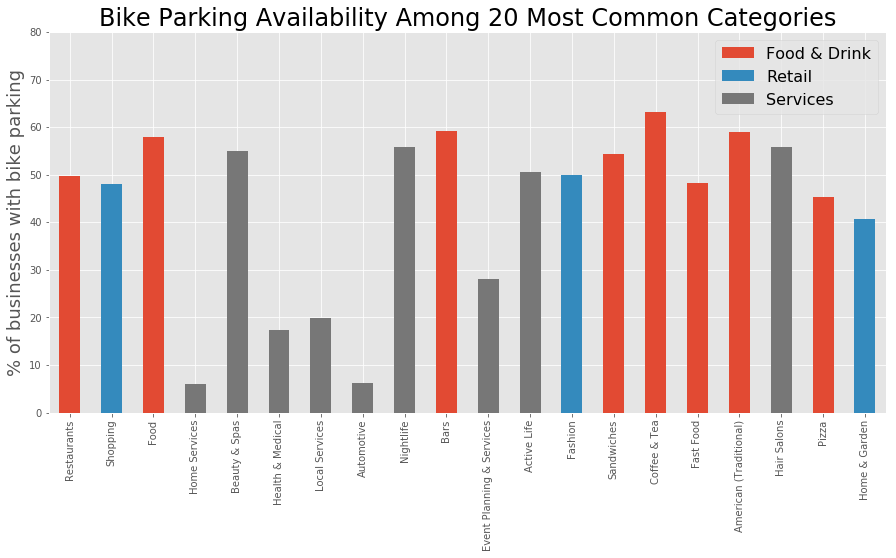

In [56]:
topcats.plot.bar(x='category', y='prop_bike_parking', color=colors)


plt.title("Bike Parking Availability Among 20 Most Common Categories", fontsize=24)
plt.ylabel("% of businesses with bike parking", fontsize=18)
plt.xlabel("")
plt.ylim(0, 80)
plt.legend(handles=legend_elements, fontsize=16)
plt.show()

We can see that generally, about 40-60% of the businesses in each category among this top 20 list have bike parking available, with the exception of a few services categories which have noticeably lower proportions.

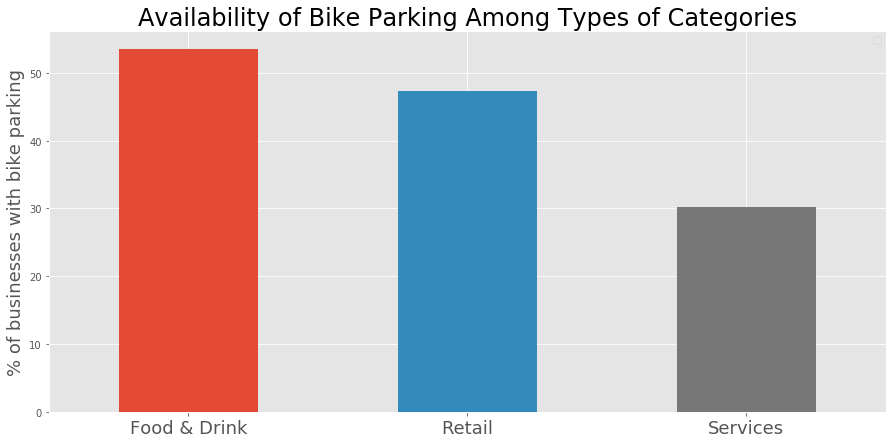

In [94]:
# df is the dataframe from the end of the previous section where we looked at our 3 generalized categories
df['prop_bike_parking'] = df.apply(lambda row: 100*row.bike_parking/row['count'], axis=1)

df.plot.bar(x='cat', y='prop_bike_parking', color=['C0','C1','C3'])


plt.xticks(rotation=0, fontsize=18)
plt.xlabel("")
plt.ylabel("% of businesses with bike parking", fontsize=18)
plt.title("Availability of Bike Parking Among Types of Categories", fontsize=24)
plt.legend("")
plt.show()

Looking at our simplified types, we can see that bike parking is most common for food & drink businesses, closely followed by retail businesses. Bike parking is less common among businesses falling in the services category.

When we start looking at the list of categories where bike parking is most or least common among the entire dataset, on both ends we get lots of categories with very few businesses recorded as having that category tag. This does not help us answer us the question of which types of businesses tend to have bike parking, so we will only look at categories that show up in the dataset at least 15 times. This cutoff is fairly arbitrary, but is still based on a bit of investigation into the data: as we will see, most categories in the following list have much more than 15 observations.

In [88]:
topbike = cats[cats['count'] >= 15].sort_values('prop_bike_parking', ascending=False)
topbike.head(10)

category  count  bike_parking  prop_bike_parking
203             Beer Gardens     80            69          86.250000
705        Basketball Courts     17            14          82.352941
205  Bike Repair/Maintenance    284           233          82.042254
786            Rock Climbing     33            27          81.818182
697          Ethical Grocery     21            17          80.952381
724           Used Bookstore     30            24          80.000000
670            Vinyl Records    140           112          80.000000
466          Mountain Biking     82            65          79.268293
734       Threading Services    279           220          78.853047
561             Whiskey Bars     50            39          78.000000

Above are shown the business categories where bike parking is most common (the column `prop_bike_parking` shows the % of such businesses that have bike parking). This list consists of businesses focused on serving alcohol, businesses providing bike services, businesses that provide active lifestyle services (basketball courts, rock climbing), and also some businesses that don't belong to any of these categorizations, and don't really form a group among themselves either. 

We won't show this, but if we continue to go down the list, businesses serving alcohol, businesses providing bike services, and businesses providing active lifestyle services all show up frequently, so it seems that these types of categories tend to have bike parking most commonly. 

Intuitively, this makes a lot of sense. It's no surprise that businesses providing bike services have bike parking. People that use the active lifestyle services are likely very interested in biking to the locations of these services, so again it is no surprise that such businesses frequently offer bike parking.

Perhaps the only somewhat surprising insight is that businesses focused on serving alcohol are so high up the list. Riding a bike while intoxicated is illegal both in the US and in Canada, but it seems that this is not frowned upon as much as driving under the influence, so businesses provide bike parking to direct customers to choose what is considered the lesser of two evils if they really have to. This is a very subjective perspective, and could very much not be actual explanation behind it. Based on the data we have, it is impossible to actually explain this phenomenon.

There are 24 categories where at least 75% of businesses provide bike parking.

The bottom of the list is much more packed: there are 93 categories where not a single business falling into each category has bike parking available. Keep in mind that we are still looking at categories with at least 15 observations. There does not appear to be a common characteristic between these categories: they range from religious schools to car brokers. Perhaps the most general insight we can provide is that a lot of these businesses provide services, which matches what we noticed when looking at the most frequent categories.

When we look at the categories that have at least one business with bike parking, the bottom of the list consists of categories that have hundreds or thousands of observations, but only in one to three cases does such a business have bike parking. Again, this list generally consists of businesses providing services.

### Relationship Between Rating Count and Star Rating

We want to investigate whether having a greater review count leads to a better rating. Recall that each business' rating is given in the column `stars`, which ranges from ranges from 0-5 with a step of 0.5.

Let's plot our two columns on a scatterplot:

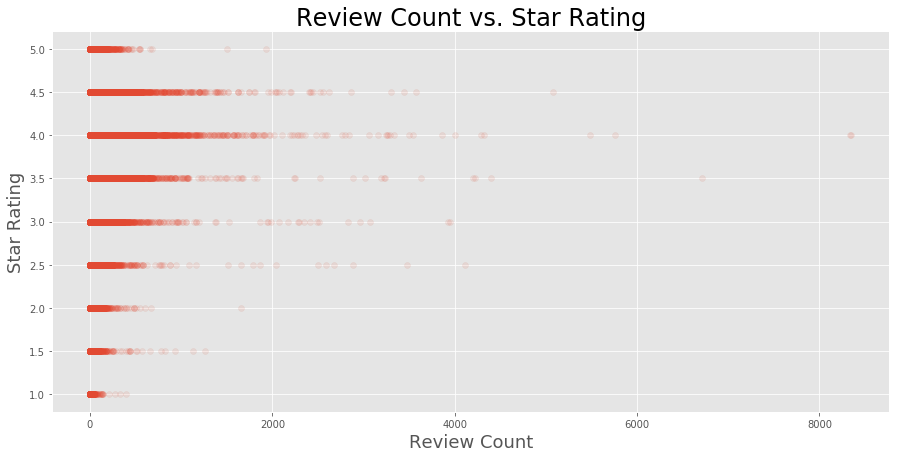

In [200]:
fig, ax = plt.subplots()

ax.scatter(x=business.review_count, y=business.stars, alpha=0.1)

plt.title("Review Count vs. Star Rating", fontsize=24)
plt.xlabel("Review Count", fontsize=18)
plt.ylabel("Star Rating", fontsize=18)
plt.show()

There are a lot of observations in our dataset, so we've made each point transparent to see the actual relationship between the variables. It does not seem like there is much going on, the data has a lot of variance, but we can still notice that higher ratings are more common for businesses with higher review counts.

We can fit a linear regression model to our data to get a more clear idea of the relationship.

In [98]:
# Create linear regression model
x = np.array(business.review_count).reshape((-1,1))
y = np.array(business.stars)
    
reg = LinearRegression().fit(x, y)

In [99]:
reg.score(x,y)

0.0016668763525098387

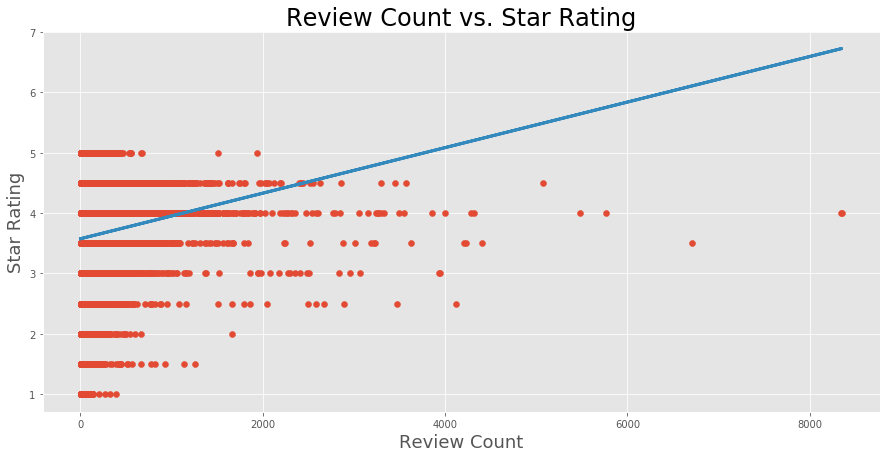

In [203]:
plt.scatter(x, y)
plt.plot(x, reg.predict(x),color='C1', linewidth=3)

plt.title("Review Count vs. Star Rating", fontsize=24)
plt.xlabel("Review Count", fontsize=18)
plt.ylabel("Star Rating", fontsize=18)
plt.show()

Whilst our linear regression model does show a positive relationship between the variables, even visually we can see that it does not fit the model well at all. This is confirmed by the model's $R^2$ value of 0.002, i.e. the model is able to explain only 0.2% of the variance in the data.

Hence we can fairly safely claim that there is no association between review count and star rating. The insight that higher ratings are more common for businesses with higher review counts is likely caused by how the ratings themselves distribute: most ratings fall in the 4.5-3 range.

## Businesses in the GTA

For this section we are interested in businesses situated in the Greater Toronto Area (GTA). People's definition of which municipalities are contained within the GTA varies, so we will be using the list of cities given in the relevant [Wikipedia article](https://en.wikipedia.org/wiki/Greater_Toronto_Area).

In [160]:
gta_cities = ['Toronto', 'Ajax', 'Clarington', 'Brock', 'Oshawa', 'Pickering', 'Scugog',
              'Uxbridge', 'Whitby', 'Burlington', 'Halton Hills', 'Milton', 'Oakville',
              'Brampton', 'Caledon', 'Mississauga', 'Aurora', 'East Gwilimbury', 'Georgina',
              'King', 'Markham', 'Newmarket', 'Richmond Hill', 'Vaughan', 'Whitchurch-Stouffville']

# We are checking the country too since the US and Canada do share many city names
gta = business[(business.country == "Canada") & (business.city.isin(gta_cities))]

### Top Franchises in the GTA

We would like to know what are the most common franchises in the GTA. Before we can start this analysis, we realise that the same issue we had with city names shows up again: there are inconsistencies in business names. For example, both "Tim Hortons" and "Tim Horton's" are present in the dataset.

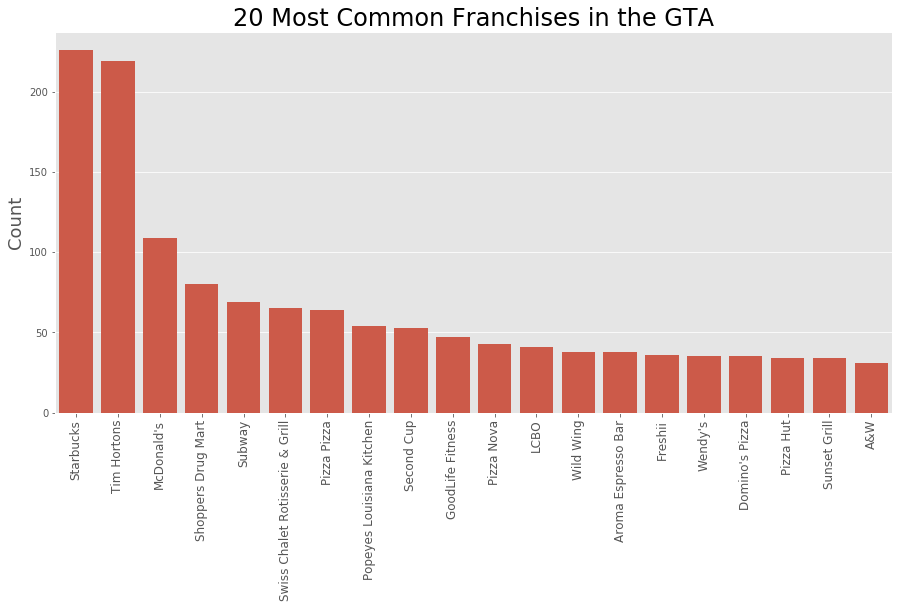

In [102]:
gta = gta.replace("Tim Horton's", "Tim Hortons")

sns.countplot(gta.name, order=gta.name.value_counts().iloc[:20].index, color='C0')

plt.xticks(rotation=90)
plt.title("20 Most Common Franchises in the GTA", fontsize=24)
plt.ylabel("Count", fontsize=18)
plt.xlabel("")
plt.xticks(fontsize=12)

plt.show()

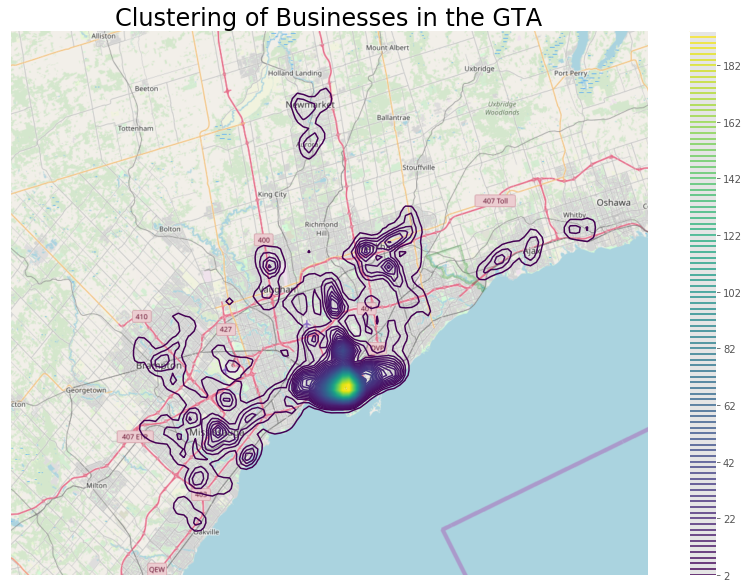

In [172]:
#toronto = gpd.read_file("data/on_roads.json")

# Create GeoDataFrame for businesses in the GTA
gdf_gta = gpd.GeoDataFrame(
    gta, geometry=gpd.points_from_xy(gta.longitude, gta.latitude), crs=world.crs)
gdf_gta.to_crs(epsg=3857)

ax = gplt.webmap(gdf_gta, projection=gcrs.WebMercator(), figsize=(15,10))
gplt.kdeplot(gdf_gta, ax=ax, n_levels=100, cbar=True, cbar_kws = {"extend": 'neither', 'drawedges': True})

plt.title("Clustering of Businesses in the GTA", fontsize=24)
plt.show()

In [173]:
def rand_jitter(arr: pd.Series) -> pd.Series:
    """Given a Series of values, jitter the values randomly and return
    the jittered series."""
    stdev = .0001*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

def jitter(x_col: pd.Series, y_col: pd.Series) -> Tuple[pd.Series]:
    """Given Pandas Series representing the longitude and latitude coordinates
    present in the dataset, jitter both columns and test if the jittering was
    successful. Return the jittered columns"""
    x_col = rand_jitter(x_col)
    y_col = rand_jitter(y_col)
    
    # Check that we no longer have two points with the same coordinates
    regroup_sizes = (
            pd.DataFrame()
            .assign(x=x_col, y=y_col)
            .groupby(['x', 'y'])
            .size()
        )
    assert not (regroup_sizes > 1).any()
    
    return (x_col, y_col)

# Jitter columns and create new Point objects
new_x, new_y = jitter(gdf_gta.longitude, gdf_gta.latitude)
for i, row in gdf_gta.iterrows():
    gdf_gta.loc[i, 'geometry'] = Point(new_x[i], new_y[i])



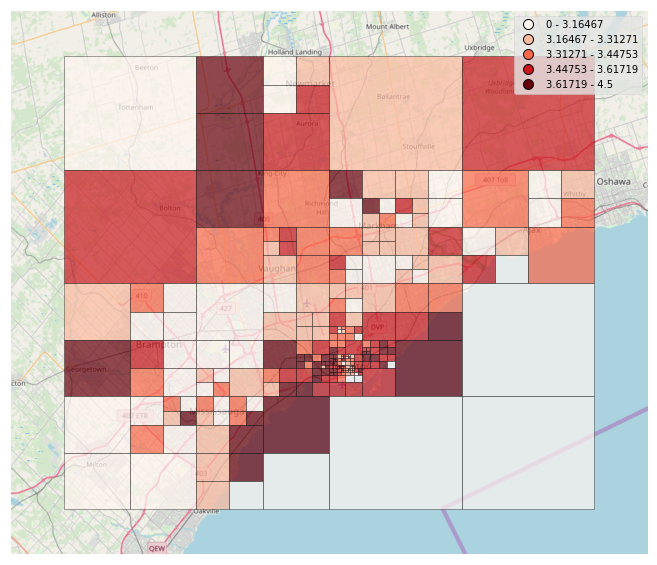

In [193]:
ax = gplt.quadtree(gdf_gta, edgecolor='black', nmax=5,
                   hue='stars', cmap='Reds', alpha=0.7, scheme='Quantiles',
                   projection=gcrs.WebMercator(), figsize=(15,10), legend=True)
gplt.webmap(gdf_gta, projection=gcrs.WebMercator(), ax=ax)

plt.show()

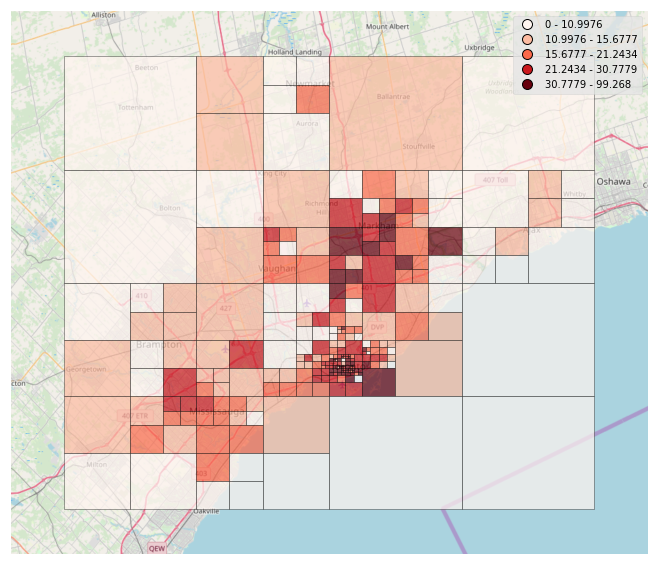

In [195]:
ax = gplt.quadtree(gdf_gta, edgecolor='black', nmax=5,
                   hue='review_count', cmap='Reds', alpha=0.7, scheme='Quantiles',
                   projection=gcrs.WebMercator(), figsize=(15,10), legend=True)
gplt.webmap(gdf_gta, projection=gcrs.WebMercator(), ax=ax)

plt.show()

In [194]:
gdf_gta.head()

business_id                        name  \
1   QXAEGFB4oINsVuTFxEYKFQ  Emerald Chinese Restaurant   
5   68dUKd8_8liJ7in4aWOSEA               The UPS Store   
19  zSpQmEBvRe3IhTUlMSA6HQ          Totum Life Science   
26  C9oCPomVP0mtKa8z99E3gg               Bakery Gateau   
27  C9keC4mWuXdl2mYFHZXudQ         Uncle Otis Clothing   

                                              address         city state  \
1                                30 Eglinton Avenue W  Mississauga    ON   
5   Credit Valley Town Plaza, F2 - 6045 Creditview Rd  Mississauga    ON   
19                       445 King Street W, Suite 101      Toronto    ON   
26                        865 York Mills Road, Unit 1      Toronto    ON   
27                                      26 Bellair St      Toronto    ON   

   postal_code   latitude  longitude  stars  review_count  is_open  \
1      L5R 3E7  43.605499 -79.652289    2.5           128        1   
5      L5V 0B1  43.599475 -79.711584    2.5             3        1   
19     M5V 1K4  43.645041 -79.395799    4.0            23        1   
26     M3B 1Y6  43.754093 -79.349548    4.5             8        1   
27     M5R 2C7  43.670744 -79.391385    5.0            12        1   

                                           attributes  \
1   {'RestaurantsReservations': 'True', 'GoodForMe...   
5   {'BusinessParking': '{'garage': False, 'street...   
19  {'AcceptsInsurance': 'True', 'ByAppointmentOnl...   
26  {'RestaurantsDelivery': 'False', 'RestaurantsP...   
27  {'RestaurantsPriceRange2': '3', 'BusinessParki...   

                                           categories  \
1   Specialty Food, Restaurants, Dim Sum, Imported...   
5   Shipping Centers, Couriers & Delivery Services...   
19  Trainers, Health & Medical, Active Life, Physi...   
26                                     Bakeries, Food   
27  Fashion, Sporting Goods, Men's Clothing, Shopp...   

                                                hours  \
1   {'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W...   
5   {'Monday': '9:0-19:0', 'Tuesday': '9:0-20:0', ...   
19  {'Monday': '6:0-22:0', 'Tuesday': '6:0-22:0', ...   
26  {'Monday': '9:0-20:0', 'Tuesday': '9:0-20:0', ...   
27  {'Monday': '11:30-19:0', 'Tuesday': '11:30-19:...   

                      geometry country  
1   POINT (-79.65233 43.60546)  Canada  
5   POINT (-79.71164 43.59945)  Canada  
19  POINT (-79.39577 43.64508)  Canada  
26  POINT (-79.34942 43.75411)  Canada  
27  POINT (-79.39140 43.67069)  Canada

### Tim Hortons and Starbucks

In [167]:
coffee = gta[(gta['name'] == 'Tim Hortons') | (gta['name'] == 'Starbucks')]
gdf_coffee = gdf_gta[(gdf_gta['name'] == 'Tim Hortons') | (gdf_gta['name'] == 'Starbucks')]

starbucks = gta[gta['name'] == 'Starbucks']
tims = gta[gta['name'] == 'Tim Hortons']

gdf_star = gdf_gta[gdf_gta['name'] == 'Starbucks']
gdf_tims = gdf_gta[gdf_gta['name'] == 'Tim Hortons']

In [168]:
len(gdf_star.index)
#len(gdf_tims.index)

235

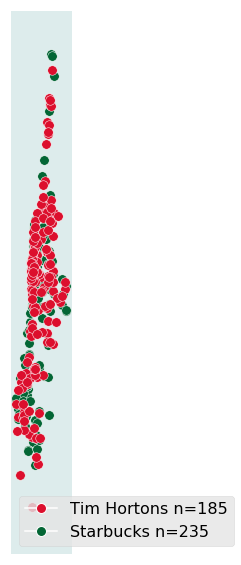

In [169]:
temp_star = gdf_star.to_crs(epsg=3857)
temp_tims = gdf_tims.to_crs(epsg=3857)

ax = gplt.webmap(gdf_coffee, projection=gcrs.WebMercator(), figsize=(15,10))
temp_star.plot(ax=ax, color=colors[1], edgecolor='white', markersize=90)
temp_tims.plot(ax=ax, color=colors[0], edgecolor='white', markersize=90)

points = [Line2D([0],[0], marker='o', color='white', label='Tim Hortons n=185',
                 markerfacecolor=colors[0], markersize=10),
         Line2D([0],[0], marker='o', color='white', label='Starbucks n=235',
                 markerfacecolor=colors[1], markersize=10),]


plt.legend(handles=points, fontsize=16)
plt.show()

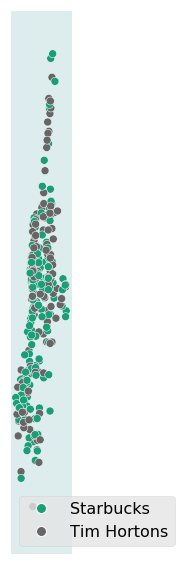

In [153]:
# Thematic colors for Tim Hortons and Starbucks
colors = ['#dc0f2d', '#036635']

ax = gplt.webmap(gdf_coffee, projection=gcrs.WebMercator(), figsize=(15,10))
gplt.pointplot(gdf_coffee, ax=ax, hue='name', cmap='Dark2', legend=True, legend_kwargs={'fontsize': 16}, s=8,
              edgecolor='white')

plt.show()

In [132]:
gdf_coffee.crs

{'init': 'epsg:4326'}

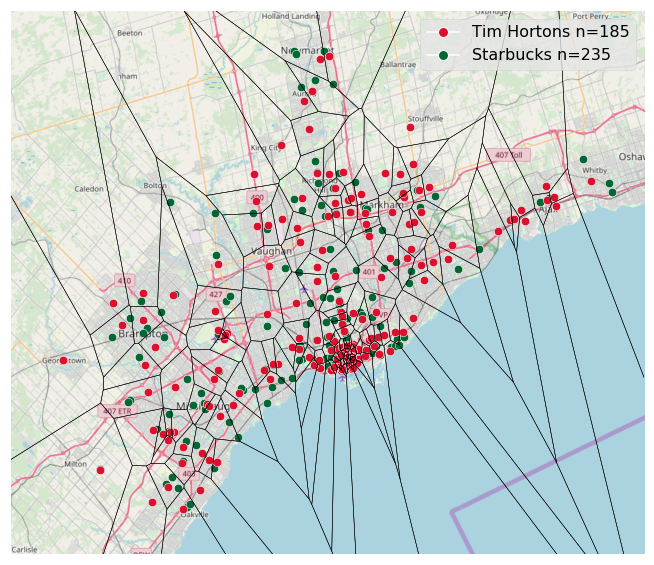

In [221]:
ax = gplt.webmap(gdf_coffee, projection=gcrs.WebMercator(), figsize=(15,10))
gplt.voronoi(gdf_tims, ax=ax)
temp_star.plot(ax=ax, color=colors[1], edgecolor='white', markersize=70)
temp_tims.plot(ax=ax, color=colors[0], edgecolor='white', markersize=70)

points = [Line2D([0],[0], marker='o', color='white', label='Tim Hortons n=185',
                 markerfacecolor=colors[0], markersize=10),
         Line2D([0],[0], marker='o', color='white', label='Starbucks n=235',
                 markerfacecolor=colors[1], markersize=10),]


plt.legend(handles=points, fontsize=16)
plt.show()

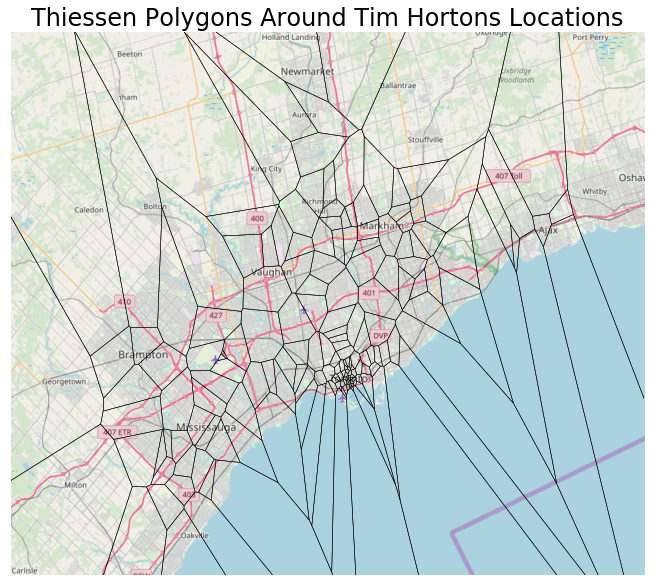

In [187]:
ax = gplt.webmap(gdf_coffee, projection=gcrs.WebMercator(), figsize=(15,10))
gplt.voronoi(gdf_tims, ax=ax)
#gplt.pointplot(gdf_coffee, ax=ax, hue='name', cmap='Dark2', legend=True, legend_kwargs={'fontsize': 16}, s=8,
              #edgecolor='white')
gdf_coffee.plot(ax=ax)

plt.title("Thiessen Polygons Around Tim Hortons Locations", fontsize=24)
plt.show()

In [69]:
# Extract coordinates of Tim Hortons locations as tuples so we can create a Voronoi object
points = []
for i, row in tims.iterrows():
    points.append((row.longitude, row.latitude))

# Outer Voronoi polygons are infinite in size, so we add 6 new points to bound as many as reasonably
# possible in finite polygons.
# We look at the max and min x,y values for the coordinates of Tim Hortons locations, and generate
# points that are slightly further out
edges = gdf_tims.total_bounds
points.append((edges[0]-0.01, edges[1]-0.01))
points.append((edges[0]-0.01, edges[3]+0.01))
points.append((edges[2]+0.01, edges[1]-0.01))
points.append((edges[2]+0.01, edges[3]+0.01))
points.append(((edges[0]+edges[2])/2, edges[1]-0.01))
points.append(((edges[0]+edges[2])/2, edges[3]+0.01))
points.append(((edges[0]-0.01, (edges[1] + edges[3])/2)))
points.append(((edges[2]+0.01, (edges[1] + edges[3])/2)))

# Create Voronoi object
vor = scp.spatial.Voronoi(points=points)

In [83]:
# Get the boundaries of finite polygons. Infinite polygons have a -1 entry in them.
lines = [
    LineString(vor.vertices[line])
    for line in vor.ridge_vertices
    if -1 not in line
]
# Create polygons based on lines, create DataFrame out of polygons
polygons = [pol for pol in polygonize(lines)]
pol_df = pd.DataFrame(polygons)
pol_df.columns=['polygon']

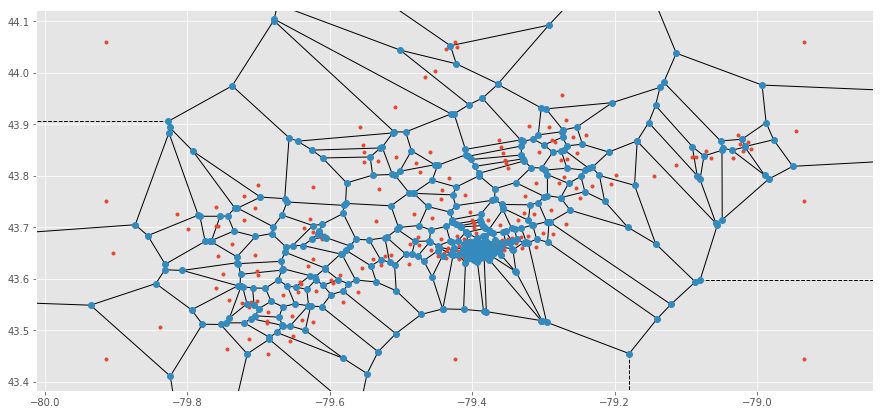

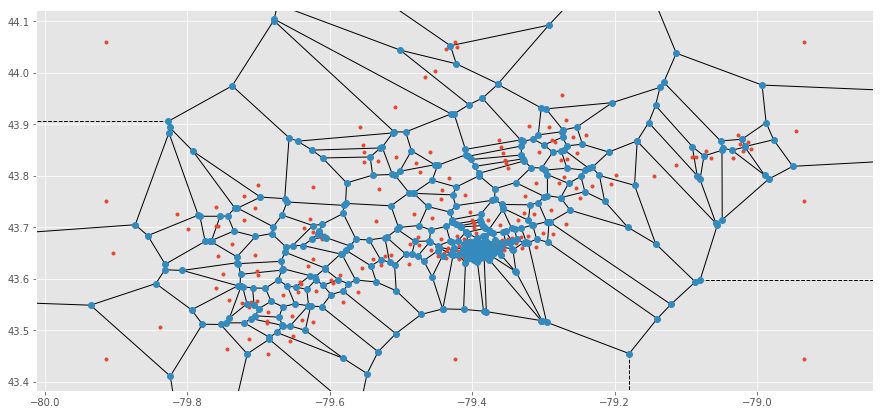

In [131]:
scp.spatial.voronoi_plot_2d(vor)

In [135]:
def get_poly_statistics(row: pd.Series) -> int:
    """Given a Pandas Series representing a row about a Voloronoi polygon, compute and return
    how many Starbucks locations are contained within it."""
    
    n_star = 0
    for i, star in starbucks.iterrows():
        # Count number of Starbucks in polygon
        if star.geometry.within(row.polygon):
            n_star += 1
        
    # Code adapted from https://stackoverflow.com/questions/51554602/how-do-i-get-the-area-of-a-geojson-polygon-with-python
    polygon = row.polygon
    geom_area = ops.transform(
    partial(
    pyproj.transform,
    pyproj.Proj(init='EPSG:4326'),
    pyproj.Proj(
        proj='aea',
        lat1=polygon.bounds[1],
        lat2=polygon.bounds[3])),
    polygon)    
    return pd.Series([n_star, geom_area.area])

def get_n_starbucks(row: pd.Series) -> int:
    n_star = 0
    for i, star in starbucks.iterrows():
        # Count number of Starbucks in polygon
        if star.geometry.within(row.polygon):
            n_star += 1
    return n_star

def get_poly_area(row: pd.Series) -> int:
    polygon = row.polygon
    geom_area = ops.transform(
    partial(
    pyproj.transform,
    pyproj.Proj(init='EPSG:4326'),
    pyproj.Proj(
        proj='aea',
        lat1=polygon.bounds[1],
        lat2=polygon.bounds[3], preserve_units=True)),
    polygon) 
    return geom_area.area
#pol_df[['n_starbucks', 'area_m2']] = pol_df.apply(lambda row: get_poly_statistics(row), axis=1)
#pol_df.n_starbucks = pol_df.apply(lambda row: int(row), axis=1)
pol_df['n_starbucks'] = pol_df.apply(lambda row: get_n_starbucks(row), axis=1)
pol_df['area_m2'] = pol_df.apply(lambda row: get_poly_area(row), axis=1)

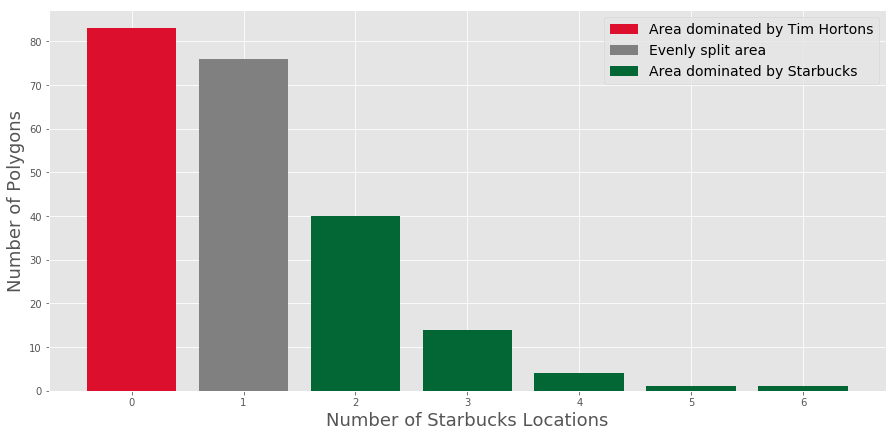

In [223]:
fig, ax = plt.subplots()

count_n = pol_df.groupby('n_starbucks').count()

ax = plt.bar(x=count_n.index, height=count_n.polygon,
             color=(colors[0], 'gray', colors[1], colors[1], colors[1], colors[1], colors[1]))

legend_elements= [Patch(facecolor=colors[0], label='Area dominated by Tim Hortons'),
                  Patch(facecolor='gray', label = 'Evenly split area'),
                  Patch(facecolor=colors[1], label = 'Area dominated by Starbucks')]

plt.legend(handles=legend_elements, fontsize=14)    

#plt.suptitle("Number of Starbucks Locations in Thiessen Polygons", fontsize=24)
#plt.title("Around Tim Hortons Locations")
plt.xlabel("Number of Starbucks Locations", fontsize=18)
plt.ylabel("Number of Polygons", fontsize=18)
plt.xticks([0,1,2,3,4,5,6])
plt.show()

The majority of of Tim Hortons locations are situated such that they are the closest neighbour to just a single or no Starbucks locations - this is a favourable situation for Tim Hortons, since this means that for some region around each location there is usually just one or none Starbucks locations. Only for very few Tim Hortons locations is there a situation where there's a lot of Starbucks locations around them, meaning that Starbucks is dominating that are.

However, it may just be that this is happening since the areas with one or no Starbucks locations are very small, so we should investigate the area sizes for our polygons.

In [150]:
pol_df.groupby('n_starbucks').sum()

area_m2
n_starbucks              
0            3.000630e+09
1            1.635202e+09
2            3.730377e+09
3            1.084457e+09
4            3.316363e+07
5            1.075380e+07
6            1.331911e+06

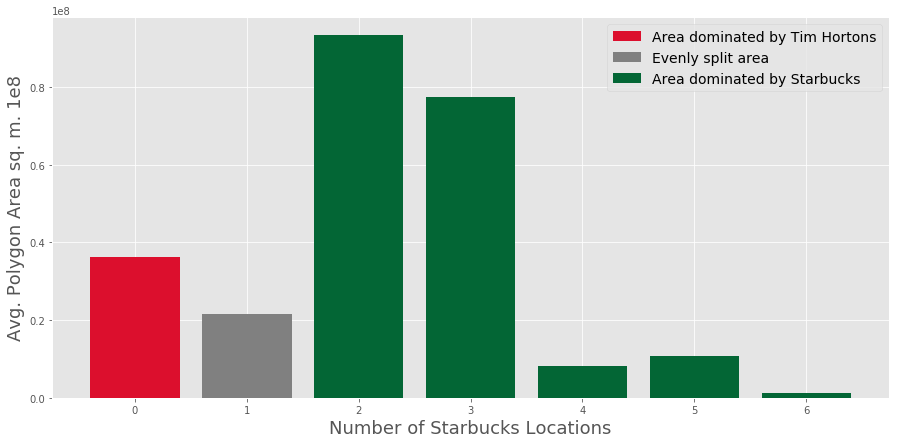

In [224]:
mean_area = pol_df.groupby('n_starbucks').mean().reset_index()

ax = plt.bar(x=mean_area.index, height=mean_area.area_m2,
             color=(colors[0], 'gray', colors[1], colors[1], colors[1], colors[1], colors[1]))

legend_elements= [Patch(facecolor=colors[0], label='Area dominated by Tim Hortons'),
                  Patch(facecolor='gray', label = 'Evenly split area'),
                  Patch(facecolor=colors[1], label = 'Area dominated by Starbucks')]

plt.legend(handles=legend_elements, fontsize=14)

#plt.suptitle("Average Area of Thiessen Polygons", fontsize=24)
#plt.title("Around Tim Hortons Locations Per N of Starbucks in Polygon")
plt.xlabel("Number of Starbucks Locations", fontsize=18)
plt.ylabel("Avg. Polygon Area sq. m. 1e8", fontsize=18)
plt.show()

This graph provides us with a somewhat different interpretation. The areas where there are 2 or 3 Starbucks locations per a single Tim Hortons are significantly larger in size than those where Tim Hortons locations dominate. The areas where there are 4 or more Starbucks locations per a single Tim Hortons location are very small in size - these are likely the downtown areas of the cities in the GTA.



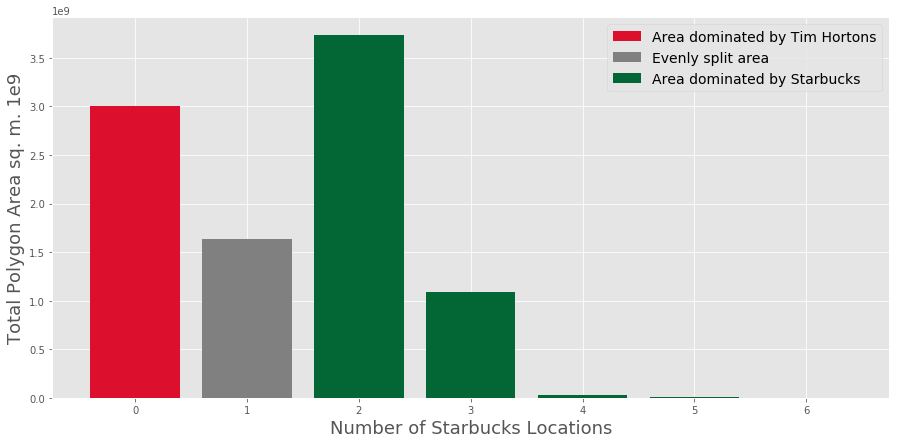

In [226]:
sum_area = pol_df.groupby('n_starbucks').sum().reset_index()

ax = plt.bar(x=sum_area.index, height=sum_area.area_m2,
             color=(colors[0], 'gray', colors[1], colors[1], colors[1], colors[1], colors[1]))

legend_elements= [Patch(facecolor=colors[0], label='Area dominated by Tim Hortons'),
                  Patch(facecolor='gray', label = 'Evenly split area'),
                  Patch(facecolor=colors[1], label = 'Area dominated by Starbucks')]

plt.legend(handles=legend_elements, fontsize=14)

#plt.suptitle("Summed Area of Thiessen Polygons", fontsize=24)
#plt.title("Around Tim Hortons Locations Per N of Starbucks in Polygon")
plt.xlabel("Number of Starbucks Locations", fontsize=18)
plt.ylabel("Total Polygon Area sq. m. 1e9", fontsize=18)
plt.show()